# Алгоритм 1: метод проекции градиента с граничениями

In [19]:
import scipy.integrate
import numpy as np

%load_ext autoreload
%autoreload 2

### Инициализация параметров

In [3]:
lnsp = np.linspace(0, 1, 10_000)

a = np.sin(lnsp)
b = np.cos(lnsp) + np.sin(lnsp) / 2
scipy.integrate.simpson(b, dx=1/len(b))
R = 3
gamma = 2

f = np.exp(lnsp)
g = np.log(lnsp + 3)
k = lnsp ** 2 - 3

### Подготовка оболочки решения

In [15]:
from methods.gradient_projection.functional import FunctionalOracle
from methods.gradient_projection.oracles import ProjectionOracle, GradientProjectionMethod

J = FunctionalOracle(f, g, k)
Oracle = ProjectionOracle(a, R, b, gamma)
Solver = GradientProjectionMethod(Oracle, J, J.grad, x0=np.zeros(10_000), epsilon=None, max_iter=150)

10000 10000


### Решение

In [16]:
print(f'Изначальное значение функционала: {Solver.get_value()}')

Изначальное значение функционала: 31942.085966603794


In [17]:
x = Solver.run()

In [18]:
print(f'Новое оптимальное значение функционала: {Solver.get_value()}')

Новое оптимальное значение функционала: -44033.23274160677


In [19]:
print(f'Принадлежит ли оптимальный x области граничения: {Oracle.check_inside(x)}')

Принадлежит ли оптимальный x области граничения: True


# Алгоритм 2: имплементация вычислительно стабильного быстрого метода Newton-CG

In [2]:
from methods.NewtonDescend.oracles import PoisOracle, Newton_CGMethod
import pandas as pd
import numpy as np

### Чтение данных и предобработка

In [3]:
ds = pd.read_csv('dataset.csv')
X = ds.drop(columns='target')
y = ds.target

In [4]:
# cycle encode time features
data = X[['month', 'day']].copy()
data['month_sin'] = np.sin(2 * np.pi * data['month']/31)
data['month_cos'] = np.cos(2 * np.pi * data['month']/31)

data['day_sin'] = np.sin(2 * np.pi * data['day']/12)
data['day_cos'] = np.cos(2 * np.pi * data['day']/12)

# normalize other features
data2 = X.drop(columns=['month', 'day'])
data2 = (data2 - data2.mean()) / data2.std()

# add constant feature
n_samples = ds.shape[0]
X = pd.concat([data2, data[['month_sin', 'month_cos', 'day_sin', 'day_cos']]], axis=1)
X['constant'] = np.ones(n_samples)
X.head()

,lane_0,lane_1,lane_2,lane_3,lane_4,lane_5,lane_6,lane_7,lane_8,lane_9,...,lane_11,lane_12,lane_13,lane_14,lane_15,month_sin,month_cos,day_sin,day_cos,constant
0,-1.200839,-1.221582,-1.198296,-0.880348,-1.079269,-1.131425,-1.228446,-0.930486,-1.294226,-1.352611,...,-0.885145,-1.279551,-1.326210,-1.226873,-1.162284,0.201299,0.979530,0.5,0.866025,1.0
1,-1.203568,-1.221154,-1.200379,-0.854252,-1.072729,-1.138488,-1.217139,-0.927173,-1.263520,-1.311771,...,-0.841856,-1.285154,-1.341468,-1.192567,-1.170318,0.394356,0.918958,0.5,0.866025,1.0
2,-1.203568,-1.222010,-1.208713,-0.856698,-1.062920,-1.135461,-1.227033,-0.934626,-1.286399,-1.333616,...,-0.876487,-1.282353,-1.256462,-1.215233,-1.166301,0.571268,0.820763,0.5,0.866025,1.0
3,-1.206841,-1.214309,-1.216004,-0.886056,-1.070549,-1.146560,-1.239754,-0.936282,-1.325534,-1.390602,...,-0.893802,-1.294493,-1.368350,-1.236062,-1.186386,0.724793,0.688967,0.5,0.866025,1.0
4,-1.207387,-1.222437,-1.216004,-0.863630,-1.079269,-1.146560,-1.239047,-0.931314,-1.329146,-1.393451,...,-0.811554,-1.295427,-1.353092,-1.205432,-1.146217,0.848644,0.528964,0.5,0.866025,1.0


### Определение задачи

In [5]:
X = X.to_numpy()
y = y.to_numpy()

Oracle = PoisOracle(X, y)
solver = Newton_CGMethod(
    w_init = np.random.normal(scale=1e-4, size=X.shape[1]),
    f=Oracle.fun,
    grad=Oracle.grad,
    hess=Oracle.hess,
    alpha=1e-3,
    epsilon=None,
    max_iter=250
)

### Решение

In [6]:
print(f'Начальное приближение решения задачи: {solver.get_value():.4f}')

Начальное приближение решения задачи: 816.1533


In [7]:
x_star = solver.run()

In [9]:
print(f'Достигнутое оптимальное решение: {solver.get_value()}')

Достигнутое оптимальное решение: -6218939.4569855


# Алгоритм 3: симплекс метод для приведенной формы для решения задачи на максимум

In [1]:
from methods.simplex_method.oracle import SimplexMethod
import numpy as np

### Задание параметров и оболочки решения

In [2]:
c = np.array([1, -3, 2])
A = np.arange(12).reshape((4, 3))
b = np.array([2, 3, 5, 1])

solver = SimplexMethod(c, A, b, 5)

### Решение

In [3]:
print(f'Изначальное решение со всеми нулями: {solver.get_value()}')

Изначальное решение со всеми нулями: 0.0


In [4]:
optim_cords, optim_value = solver.solve()

In [5]:
print(f'Оптимальное решение: {optim_value}')

Оптимальное решение: 0.18181818181818182


# Алгоритм 4: Применение двустороннего ADMM для задачи восстановления изображения

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']

from methods.ADMM.tools import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051689191698933684..1.0307210163654816].


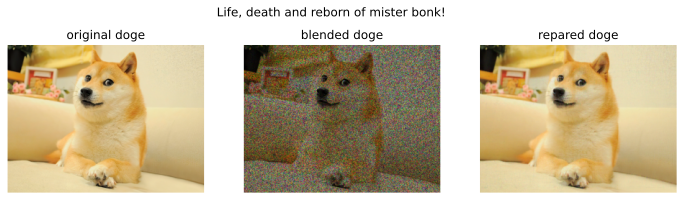

In [9]:
img = cv2.imread('doge.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
img = cv2.resize(img, (0,0), fx=0.3, fy=0.3)

r_mask, g_mask, b_mask = make_mask(*img.shape[:2], 0.5), make_mask(*img.shape[:2], 0.5), make_mask(*img.shape[:2], 0.5)


broken_image = np.zeros_like(img)
broken_image[*r_mask, 0] = img[*r_mask, 0]
broken_image[*g_mask, 1] = img[*g_mask, 1]
broken_image[*b_mask, 2] = img[*b_mask, 2]

cured = cure_image(broken_image, [r_mask, g_mask, b_mask], 0.0, 75, 2)

fig, axis = plt.subplots(1, 3)
fig.suptitle("Life, death and reborn of mister bonk!")
fig.set_figwidth(12)
fig.set_figheight(3.2)

axis[0].set_title('original doge')
axis[0].imshow(img)
axis[0].grid(False)
axis[0].axis(False)

axis[1].set_title('blended doge')
axis[1].imshow(broken_image)
axis[1].grid(False)
axis[1].axis(False)

axis[2].set_title('repared doge')
axis[2].imshow(cured)
axis[2].grid(False)
axis[2].axis(False)

plt.show()